In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.utils.random import sample_without_replacement
from sklearn.utils import resample

In [2]:
# Create data
X, y = make_classification(random_state=42, n_features=10, n_informative=5, n_redundant=0, n_samples=1000)
X = pd.DataFrame(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [3]:
clf = DecisionTreeClassifier().fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
cm

array([[110,  19],
       [ 13, 108]])

In [4]:
# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df

,Predicted 0,Predicted 1
Actual 0,110,19
Actual 1,13,108


In [5]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       129
           1       0.85      0.89      0.87       121

    accuracy                           0.87       250
   macro avg       0.87      0.87      0.87       250
weighted avg       0.87      0.87      0.87       250



In [6]:
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

Training Score: 1.0
Testing Score: 0.872


### Bagging
Instead of having one decision tree, we make 50 random trees and average their output. Decision trees try to make the best decision possible at every point. So if we use the same input, we'll get the same decision tree each time. (And, we won't get a different answer after aggregating.) To get different trees, we give them different inputs by randomly sampling the input dataset. Random sampling with replacement is known as bootstrapping. (We use replacement because a data point might occur multiple times in the random sample.) This method of creating a random ensemble is known as bootstrap aggregating, or bagging.

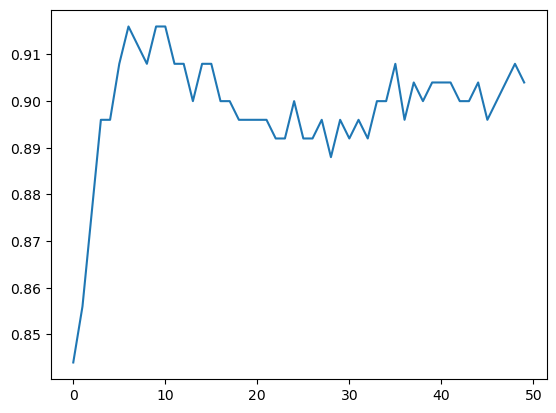

score: 0.904


In [7]:
clfs = []
scores = []
for i in range(50):
    
    # Sample the data for each new tree
    X_train_scaled_bootstrap, y_train_bootstrap = resample(X_train_scaled, y_train, random_state=i)
    
    # Create a decision tree and append it to our list of classifiers
    clf = DecisionTreeClassifier(random_state=i+200).fit(X_train_scaled_bootstrap, y_train_bootstrap)
    clfs.append(clf)
    
    # Take the median score of all the created classifiers
    y_preds = [clf.predict(X_test_scaled) for clf in clfs]
    y_pred = pd.DataFrame(y_preds).median().round()
    score = score = accuracy_score(y_test, y_pred)
    scores.append(score)

plt.plot(scores)
plt.show()
print(f'score: {score}')

In [8]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=1, n_estimators=50).fit(X_train_scaled, y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

Training Score: 0.9986666666666667
Testing Score: 0.904


We can go one step further by changing the behavior of the decision trees so that they randomly choose their splits. Counterintuitively, this can increase the accuracy of the model, even though we make each tree worse on its own.

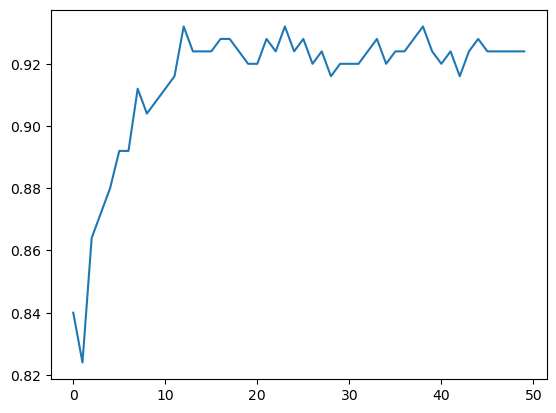

score: 0.924


In [9]:
clfs = []
scores = []
for i in range(50):
    
    # Sample the data for each new tree
    X_train_scaled_bootstrap, y_train_bootstrap = resample(X_train_scaled, y_train, random_state=i)
    
    # Create a random decision tree and append it to our list of classifiers
    clf = DecisionTreeClassifier(splitter='random', random_state=i+200).fit(X_train_scaled_bootstrap, y_train_bootstrap)
    clfs.append(clf)
    
    # Take the median score of all the created classifiers
    y_preds = [clf.predict(X_test_scaled) for clf in clfs]
    y_pred = pd.DataFrame(y_preds).median().round()
    score = score = accuracy_score(y_test, y_pred)
    scores.append(score)

plt.plot(scores)
plt.show()
print(f'score: {score}')

#### This algorithm is known as "Extremely Random Trees"
or ExtraTrees in scikit-learn

In [10]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(random_state=1, n_estimators=50).fit(X_train_scaled, y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

Training Score: 1.0
Testing Score: 0.928


## Boosting

Boosting is another ensemble method that creates many weak learners (classifiers or regressors that do slightly better than chance). Boosting uses their predictions in aggregate to create one accurate prediction. However, unlike Bagging methods, each new weak learner is trained on data that skews the training dataset to data points that the previous weak learners didn't estimate well.

In [11]:
from boost_helper_functions import bootstrap, get_estimator_weight, new_sample_weights

n_estimators = 50

estimator_weights = np.zeros(n_estimators)
estimators = [DecisionTreeClassifier(max_depth=2) for i in range(n_estimators)]

sample_weights = np.ones(len(X_train_scaled)) / len(X_train_scaled)
for i in range(50):
    estimator = estimators[i]
    
    # Fit the estimator to a bootstrapped sample
    X_bootstrap, y_bootstrap = bootstrap(X_train_scaled, y_train, sample_weights, random_state=1)
    estimator.fit(X_bootstrap, y_bootstrap)
    
    # Calculate the amount that each sample contributes to the total error
    y_predict = estimator.predict(X_train_scaled)
    errors = np.abs(y_predict - y_train)
    normalized_errors = errors / np.abs(y_predict - y_train).max()
        
    # Calculate how much say this estimator should have in the final prediction
    estimator_weights[i] = get_estimator_weight(sample_weights, normalized_errors)
    
    # Calculate which samples the next estimator should focus on more
    sample_weights = new_sample_weights(sample_weights, normalized_errors)
    
y_preds = [reg.predict(X_test_scaled) for reg in estimators]
y_pred = pd.DataFrame(y_preds).median().round()
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.95      0.90       129
           1       0.94      0.82      0.88       121

    accuracy                           0.89       250
   macro avg       0.90      0.89      0.89       250
weighted avg       0.89      0.89      0.89       250



In [12]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(random_state=1, n_estimators=50, base_estimator=DecisionTreeClassifier(max_depth=2)).fit(X_train_scaled, y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

Training Score: 1.0
Testing Score: 0.896
